# Enfermedades Cardiacas -KNN
### Mauricio Tumalan Castillo - A01369288
### Tecnológico de Monterrey - TC3006C.101

En este proyecto, utilizamos el algoritmo K-Nearest Neighbors (KNN) para clasificar a individuos según la presencia de enfermedades cardíacas. La clasificación se basa en un conjunto de datos que contiene varios atributos médicos. Se utilizarán 3 métricas distintas, las cuales serán implementadas tanto "manualmente" como con la librería Sci-kit Learn, se compararán los resultados obtenidos y se definirá acorde a las precisiones de los modelos si es conveniente utilizar estas librerías o no.

In [76]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import codecs
from operator import itemgetter
from statistics import mode
import time

# NumPy y Pandas para manipulación de datos
# Scikit-learn para implementar el algoritmo KNN y evaluar el modelo
# Matplotlib para visualización de datos
# os y codecs para leer los archivos de texto
# itemgetter para obtener el elemento más común en una lista
# mode para obtener la moda de una lista  

El conjunto de datos contiene 303 muestras, de las cuales se tomaron 242 para entrenamiento y 61 de prueba, hay 14 columnas separadas por comas que describen la siguiente información:

1. Edad: muestra la edad del individuo
2. Sexo: muestra el género del individuo (1=hombre, 0=mujer)
3. Dolor en el pecho: muestra el tipo de dolor que experimenta el individuo (1=angina tipica, 2= angina atipica, 3=dolor no anginoso, 4=asintomático)
4. Presion arterial: muestra el valor de la presión arterial del individuo en mmHg (unidad).
5. Colesterol en suero: muestra el colesterol ennsuero en mg/dl (unidad).
6. Glucosa en ayunas: Compara el valor de glucosa en ayunas de un individuo. SI la glucosa en ayunas > 120 mg/dl entonces: 1 (verdadero); de lo contrario: 0 (falso).
7. ECG en reposo: muestra resultados electrocardiográficos en reposo (0=normal, 1=Anomalía de la onda ST-T, 2=hipertrofia ventricular izquierda)
8. Frecuencia cardíaca: muestra la frecuencia cardíaca máxima alcanzada por un individuo.
9. Angina inducida por ejercicio (1=si, 0=no)
10. Depresión del segmento ST inducida por el ejercicio en relación con el reposo: muestra el valor que es un número entero o flotante.
11. Segmento ST de ejercicio máximo (1=pendiente ascendente, 2=plana, 3=pendiente descendente)
12. Número de vasos principales (0-3) coloreados por fluorosopía: muestra el valor como entero o flotante.
13. presencia de talasemia: (3=normal, 6=defecto corregido, 7=defecto reversible)
14. Diagnóstico de enfermedad (etiqueta de clasificación): muestra si el individuo padece o no una enfermedad cardíaca (Ausencia o Presencia)

In [77]:
# Cargar los datos de entrenamiento
current_path = os.getcwd()
training_data = os.path.join(current_path, 'Datos/training.txt')
test_data = os.path.join(current_path, 'Datos/test.txt')

In [78]:
# Inicializar las listas de datos y etiquetas
training = []
trainingLabels = []
test = []
testLabels = []

In [79]:
# Leer los datos de entrenamiento y prueba de los archivos de texto y almacenarlos en las listas correspondientes
with codecs.open(training_data, 'r', 'utf-8') as file:
    for line in file:
        elements = (line.rstrip('\n')).split(',')
        #append all the elements to the training list
        training.append([float(x) for x in elements[:-1]])
        #append the last element to the list as a label, changing the label to 0 or 1
        if elements[-1] == 'Present':
            trainingLabels.append(float(1))
        else:
            trainingLabels.append(float(0))


with codecs.open(test_data, 'r', 'utf-8') as file:
    for line in file:
        elements = (line.rstrip('\n')).split(',')
        #append all the elements to the test list
        test.append([float(x) for x in elements[:-1]])
        #append the last element to the list as a label
        if elements[-1] == 'Present':
            testLabels.append(float(1))
        else:
            testLabels.append(float(0))

Se necesitan las siguientes tres funciones que calculen diferentes tipos de distancias entre dos puntos en un espacio multidimensional: Manhattan, Minkowski, y Euclidiana. Estas distancias son fundamentales en algoritmos de clasificación como el K-Nearest Neighbors (KNN), donde la similitud entre puntos se mide para hacer predicciones.

In [80]:
#Calcular la distancia entre dos puntos con la fórmula de la distancia de Manhattan
def manhattan_distance(point1, point2):
    return sum(abs(a - b) for a, b in zip(point1, point2))

#Calcular la distancia entre dos puntos con la fórmula de la distancia de Minkowski
def minkowski_distance(point1, point2, p):
    return sum(abs(a - b) ** p for a, b in zip(point1, point2)) ** (1 / p)

#Calcular la distancia entre dos puntos con la fórmula de la distancia de Euclides
def euclidean_distance(point1, point2):
    return sum((a - b) ** 2 for a, b in zip(point1, point2)) ** 0.5

La siguiente función evalúa el rendimiento del algoritmo para un rango de valores k que va del 3 al 43, el cual determina cuántos vecinos se consideran al clasificar un punto de prueba.

Se utilizan las funciones de distancia definidas anteriormente para calcular con las distintas metricas de distancia la similitud de los puntos, devolviendo la precisión obtenida para cada valor de k:

In [81]:
def classify_k_range(testLists, trainingLists, trainingLabels, testLabels, function):
    sttime = time.time()
    k_values = range(3, 44)  # Rango de k desde 3 hasta 43
    accuracies = [] # Lista para almacenar las precisión de cada valor de k

    for k in k_values:
        correct_predictions = 0 # Contador para el número de predicciones correctas
        
        for testList, true_label in zip(testLists, testLabels):
            distances = [] # Lista para almacenar las distancias entre testList y trainingLists
            for trainingList, label in zip(trainingLists, trainingLabels):
                # Calcular la distancia entre testList y trainingList
                if function == 'minkowski':
                    value = minkowski_distance(testList, trainingList, 5)
                elif function == 'manhattan':
                    value = manhattan_distance(testList, trainingList)
                elif function == 'euclidean':
                    value = euclidean_distance(testList, trainingList)
                distances.append((value, label))
            # Ordenar las distancias en orden ascendente
            distances.sort(key=itemgetter(0)) 
            votelabels = []
            # Tomar k elementos con las distancias más bajas hacia testList
            for x in distances[:k]:
                votelabels.append(x[1])

            # Obtener la etiqueta más común y verificar si es correcta
            predicted_label = mode(votelabels)
            if predicted_label == true_label:
                correct_predictions += 1
        
        # Calcular la precisión para el valor de k actual
        accuracy = correct_predictions / len(testLists)
        accuracies.append(accuracy)
    
    extime = time.time() - sttime
    
    return list(k_values), accuracies, extime # Devolver los valores de k y las precisiónes correspondientes

De igual forma, en el siguiente bloque está la función que utiliza la librería de Scikit-learn para implementar el algoritmo de KNN de una forma más eficiente y con menos esfuerzo que la codificación manual hecha anteriormente. Para la métrica Minkowski, se utilizará el valor de p=5

In [82]:
import time

def knn(metric):
    sttime = time.time()
    accuracies = []
    ks = range(3, 42)

    for k in ks:
        if metric == 'minkowski':
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric, p=5)
        else:
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(training, trainingLabels)
        predictions = knn.predict(test)
        accuracy = accuracy_score(testLabels, predictions)
        accuracies.append(accuracy)
    
    best_k = ks[np.argmax(accuracies)]
    best_accuracy = max(accuracies)

    extime = time.time() - sttime

    return ks, accuracies, extime

In [83]:
# Se ejecutan las funciones que contienen el KNN evaluado con Scikit-learn
ks_manhattan, accuracies_manhattan, time_manhattan = knn('manhattan')
ks_minkowski, accuracies_minkowski, time_minkowski = knn('minkowski')
ks_euclidean, accuracies_euclidean, time_euclidean = knn('euclidean')

# Se ejecutan las funciones que contienen el KNN evaluado manualmente
ks_manual_manhattan, accuracies_manual_manhattan, time_manual_manhattan = classify_k_range(test, training, trainingLabels, testLabels, 'manhattan')
ks_manual_minkowski, accuracies_manual_minkowski, time_manual_minkowski = classify_k_range(test, training, trainingLabels, testLabels, 'minkowski')
ks_manual_euclidean, accuracies_manual_euclidean, time_manual_euclidean = classify_k_range(test, training, trainingLabels, testLabels, 'euclidean')


En el siguiente bloque de código se graficarán las funciones, comparando su implementación "manual" con la de la librería de Scikit-learn

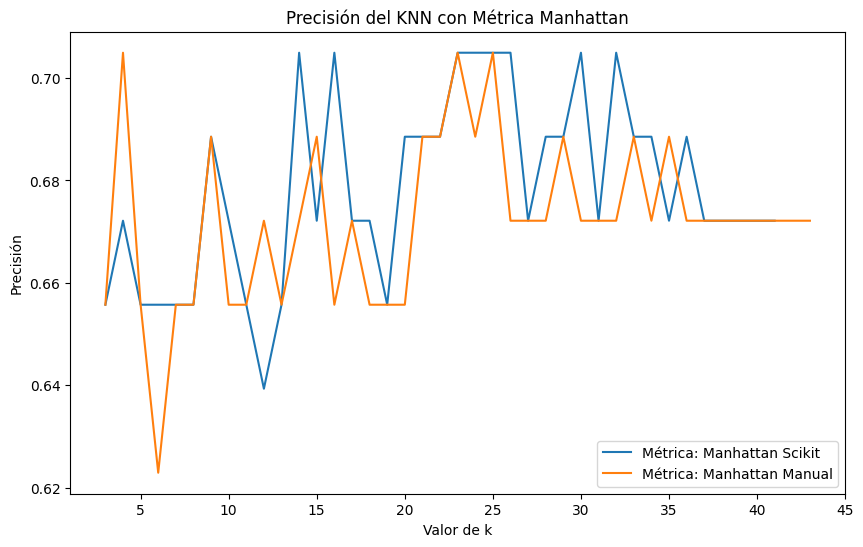

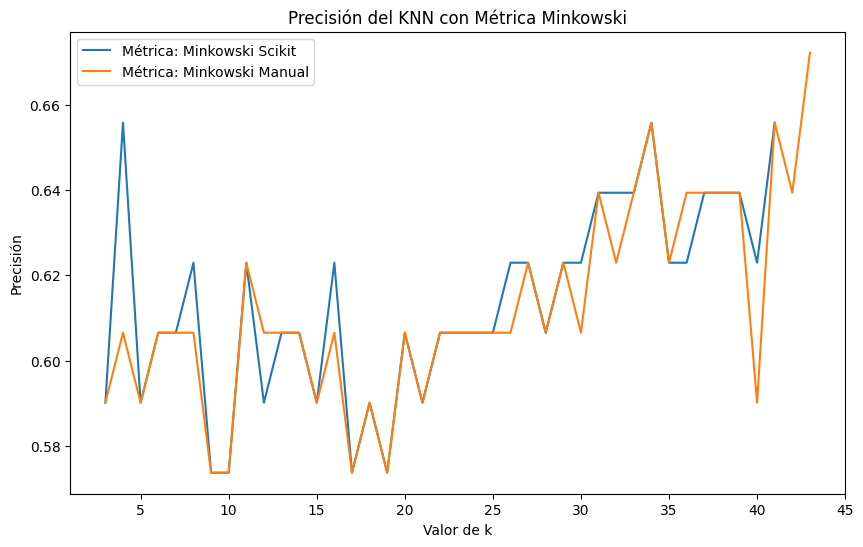

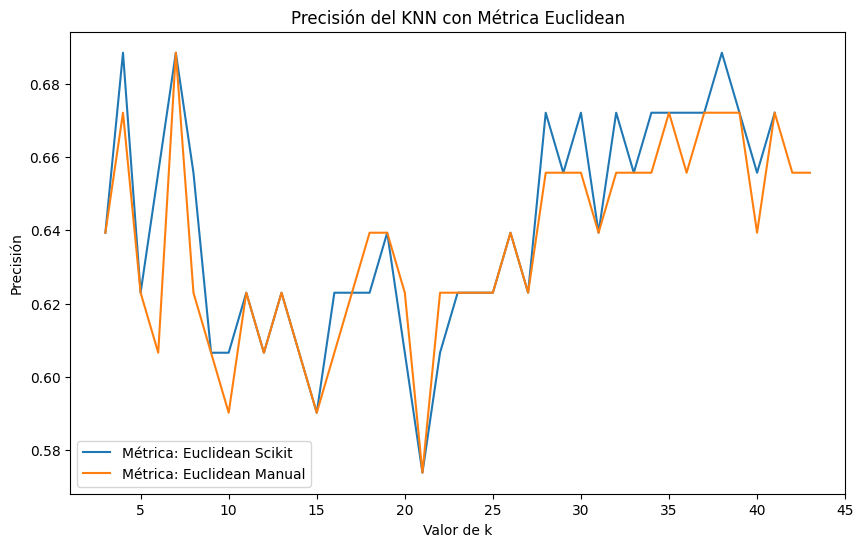

In [84]:
# Gráfico para Manhattan (Scikit-learn vs Manual)
plt.figure(figsize=(10, 6))
plt.plot(ks_manhattan, accuracies_manhattan, label='Métrica: Manhattan Scikit')
plt.plot(ks_manual_manhattan, accuracies_manual_manhattan, label='Métrica: Manhattan Manual')
plt.xlabel('Valor de k')
plt.ylabel('Precisión')
plt.title('Precisión del KNN con Métrica Manhattan')
plt.legend()
plt.show()

# Gráfico para Minkowski (Scikit-learn vs Manual)
plt.figure(figsize=(10, 6))
plt.plot(ks_minkowski, accuracies_minkowski, label='Métrica: Minkowski Scikit')
plt.plot(ks_manual_minkowski, accuracies_manual_minkowski, label='Métrica: Minkowski Manual')
plt.xlabel('Valor de k')
plt.ylabel('Precisión')
plt.title('Precisión del KNN con Métrica Minkowski')
plt.legend()
plt.show()

# Gráfico para Euclidean (Scikit-learn vs Manual)
plt.figure(figsize=(10, 6))
plt.plot(ks_euclidean, accuracies_euclidean, label='Métrica: Euclidean Scikit')
plt.plot(ks_manual_euclidean, accuracies_manual_euclidean, label='Métrica: Euclidean Manual')
plt.xlabel('Valor de k')
plt.ylabel('Precisión')
plt.title('Precisión del KNN con Métrica Euclidean')
plt.legend()
plt.show()

Se puede observar que los valores de la métrica euclidiana son bastante similares, teniendo un ligero mejor desempeño con la función que utiliza Scikit-learn, en la gráfica comparativa de Minkowski se puede apreciar un mejor desempeño al inicio con la librería de Scikit learn, para concluir con un mayor % de precisión de k con la implementación manual. Para Manhattan se observa bastante diferencia al inicio por parte de las implementaciones, viendo que al final terminan teniendo valores bastante similares entre las iteraciones de K.

En el siguiente bloque se pueden observar todas las métricas graficadas juntas, donde se puede realizar una comparación entre los resultados obtenidos con Scikit-learn y los obtenidos manualmente.

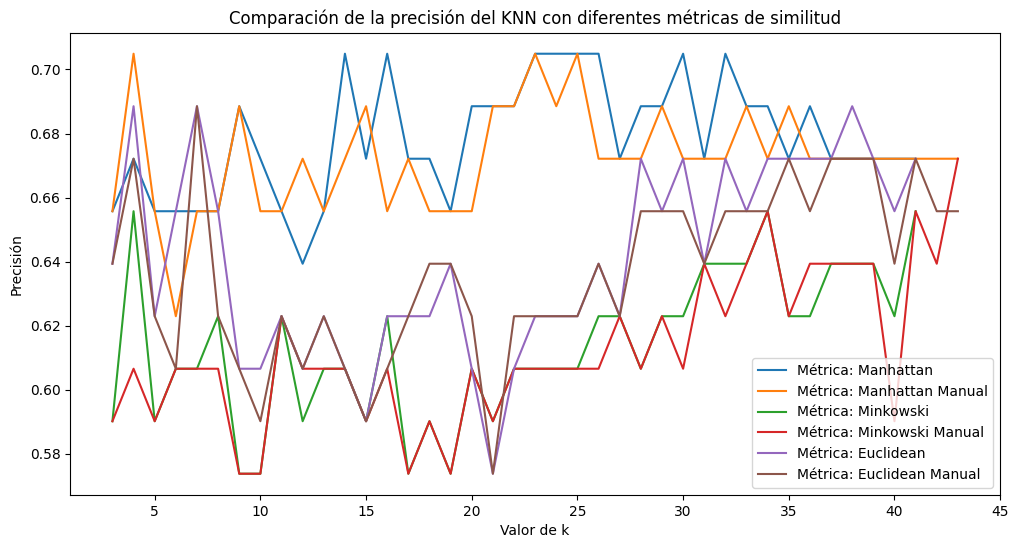

In [85]:
plt.figure(figsize=(12, 6))
# Comparación de la métrica 'manhattan'
plt.plot(ks_manhattan, accuracies_manhattan, label='Métrica: Manhattan')
# Comparación de la métrica 'manhattan' manual
plt.plot(ks_manual_manhattan, accuracies_manual_manhattan, label='Métrica: Manhattan Manual')

# Comparación de la métrica 'minkowski'
plt.plot(ks_minkowski, accuracies_minkowski, label='Métrica: Minkowski')
# Comparación de la métrica 'minkowski' manual
plt.plot(ks_manual_minkowski, accuracies_manual_minkowski, label='Métrica: Minkowski Manual')

# Comparación de la métrica 'euclidean'
plt.plot(ks_euclidean, accuracies_euclidean, label='Métrica: Euclidean')
# Comparación de la métrica 'euclidean' manual
plt.plot(ks_manual_euclidean, accuracies_manual_euclidean, label='Métrica: Euclidean Manual')

plt.xlabel('Valor de k')
plt.ylabel('Precisión')
plt.title('Comparación de la precisión del KNN con diferentes métricas de similitud')
plt.legend()
plt.show()


Se puede observar en general un mejor desempeño por la parte de la implementación de KNN con la libreria de Scikit-learn con Manhattan, y se observa el peor por la parte de Minkowski de forma "manual"

En el siguiente código de bloque se grafica el tiempo que se tardó en ejecución las funciones.

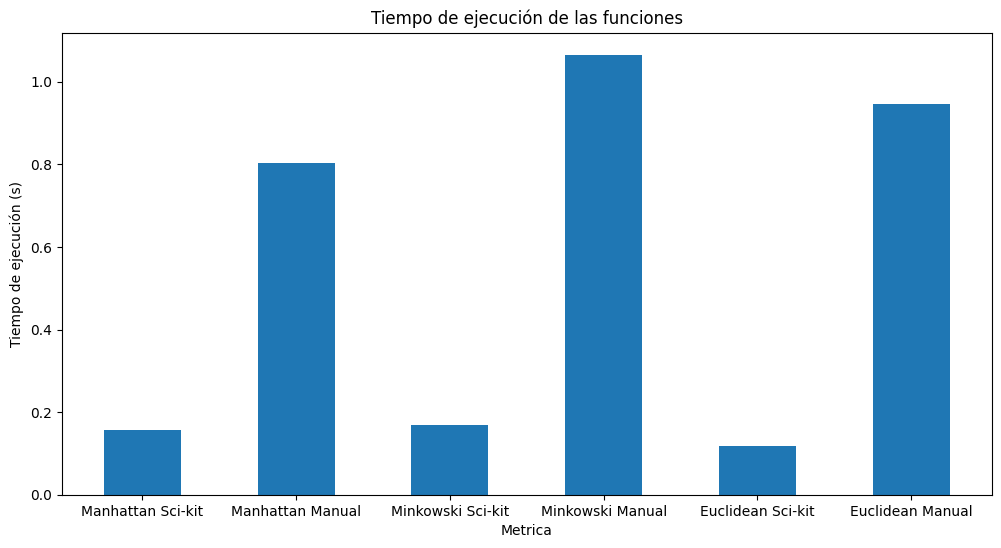

In [86]:
# Tiempos de ejecución de las métricas de similitud
metrics = ['Manhattan Sci-kit', 'Manhattan Manual', 'Minkowski Sci-kit', 'Minkowski Manual', 'Euclidean Sci-kit', 'Euclidean Manual']
times = [time_manhattan, time_manual_manhattan, time_minkowski, time_manual_minkowski, time_euclidean, time_manual_euclidean]

plt.figure(figsize=(12, 6))

# Create a bar graph with wider bars
plt.bar(metrics, times, width=0.5)
plt.xlabel('Metrica')
plt.ylabel('Tiempo de ejecución (s)')
plt.title('Tiempo de ejecución de las funciones')
plt.show()

Se puede observar un menor tiempo de ejecución al utilizar la librería de Scikit-learn, debido a la optimización de la librería para este tipo de casos.

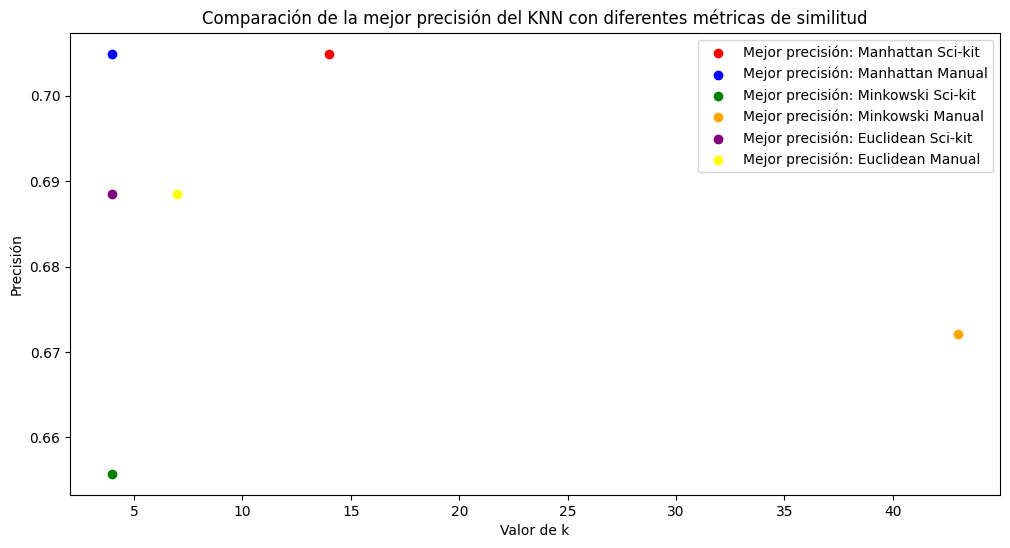

In [88]:
# Obtener la mejor precisión y el valor de k correspondiente para cada métrica, tanto con Scikit-learn como manualmente, y graficarlos todos juntos

best_accuracy_manhattan = max(accuracies_manhattan)
best_accuracy_manhattan_manual = max(accuracies_manual_manhattan)

best_accuracy_minkowski = max(accuracies_minkowski)
best_accuracy_minkowski_manual = max(accuracies_manual_minkowski)

best_accuracy_euclidean = max(accuracies_euclidean)
best_accuracy_euclidean_manual = max(accuracies_manual_euclidean)

plt.figure(figsize=(12, 6))

# Comparación de la mejor precisión de la métrica 'manhattan'
best_k = ks_manhattan[np.argmax(accuracies_manhattan)]
plt.scatter(best_k, best_accuracy_manhattan, color='red', label='Mejor precisión: Manhattan Sci-kit')
plt.scatter(ks_manual_manhattan[np.argmax (accuracies_manual_manhattan)], best_accuracy_manhattan_manual, color='blue', label='Mejor precisión: Manhattan Manual')

# Comparación de la mejor precisión de la métrica 'minkowski'
best_k = ks_minkowski[np.argmax(accuracies_minkowski)]
plt.scatter(best_k, best_accuracy_minkowski, color='green', label='Mejor precisión: Minkowski Sci-kit')
plt.scatter(ks_manual_minkowski[np.argmax (accuracies_manual_minkowski)], best_accuracy_minkowski_manual, color='orange', label='Mejor precisión: Minkowski Manual')

# Comparación de la mejor precisión de la métrica 'euclidean'
best_k = ks_euclidean[np.argmax(accuracies_euclidean)]
plt.scatter(best_k, best_accuracy_euclidean, color='purple', label='Mejor precisión: Euclidean Sci-kit')
plt.scatter(ks_manual_euclidean[np.argmax (accuracies_manual_euclidean)], best_accuracy_euclidean_manual, color='yellow', label='Mejor precisión: Euclidean Manual')

plt.xlabel('Valor de k')
plt.ylabel('Precisión')
plt.title('Comparación de la mejor precisión del KNN con diferentes métricas de similitud')
plt.legend()
plt.show()

Se puede observar que los mejores resultados fueron obtenidos por la métrica Manhattan, y los peores con Minkowski.

Tras realizar esta actividad, se puede concluir que lo ideal es implementar las librerías por su ejecución fluida y resultados equiparables con metodos manuales